In [1]:
import numpy as np
import os
from qcodes import Station
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.logger.logger import start_all_logging
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment
import matplotlib.pyplot as plt
from lab_qcodes import *

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200508-21308-qcodes.log


In [2]:
# Sempre importante iniciar o logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\lucam\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\lucam\.qcodes\logs\200508-21308-qcodes.log


# Teste

In [3]:

# Exemplo de como crirar um instrumento
PSG1 = DummySignalGenerator("SignalGenerator1")
PSG2 = DummySignalGenerator("SignalGenerator2")

In [4]:
tlist = np.linspace(0,1,100)

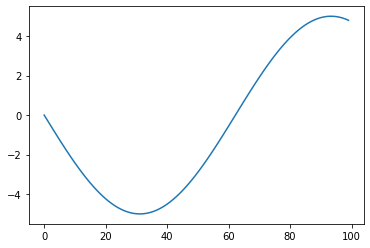

In [5]:
plt.plot(PSG1.signal(tlist))

In [6]:
osc = DummyOscilloscope('oscilloscope')

In [7]:
osc.ch1.connect_inst(PSG1)
osc.ch2.connect_inst(PSG2)

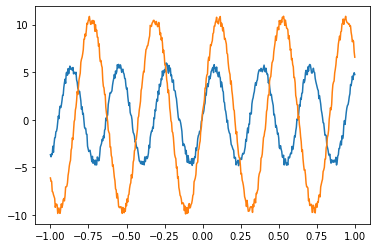

In [8]:
#Controle dos equipamentos mas sem a medida de fato
PSG1.freq.set(20)
PSG1.amp.set(5)
PSG2.freq.set(15)
PSG2.amp.set(10)
plt.plot(osc.ch1.t_axis(),osc.ch1.wavesample())
plt.plot(osc.ch2.t_axis(),osc.ch2.wavesample())

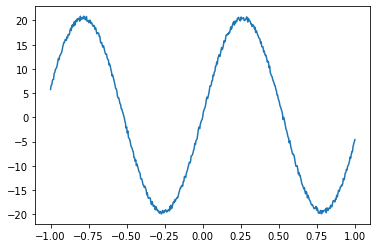

In [9]:
PSG1.amp.set(20)
PSG1.freq.set(6)
plt.plot(osc.ch1.t_axis(),osc.ch1.wavesample())

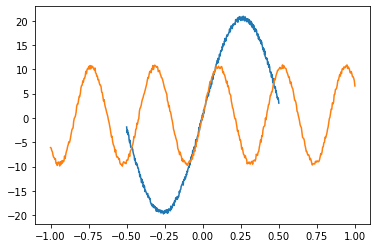

In [10]:
osc.ch1.t_stop.set(-0.5)
osc.ch1.t_start.set(0.5)
plt.plot(osc.ch1.t_axis(),osc.ch1.wavesample())
plt.plot(osc.ch2.t_axis(),osc.ch2.wavesample())

# Teste Medida 

In [11]:
# Station representa um conjunto de instrumentos
station = Station()
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'config': None,
 'default_measurement': []}

In [12]:
station.add_component(osc)

'oscilloscope'

In [13]:
# Criar um database
initialise_or_create_database_at("~/teste.db")

In [14]:
#Definir um experimento
exp = load_or_create_experiment(experiment_name='osc_teste',
                                sample_name="osc teste 1")

In [15]:
# Medida de fato
meas = Measurement(exp=exp, station=station)
meas.register_parameter(osc.ch1.wavesample)

with meas.run() as datasaver:
    datasaver.add_result((osc.ch1.t_axis, osc.ch1.t_axis()),
                         (osc.ch1.wavesample, osc.ch1.wavesample()))
    dataset = datasaver.dataset

Starting experimental run with id: 15. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1b615caab48>], [None])

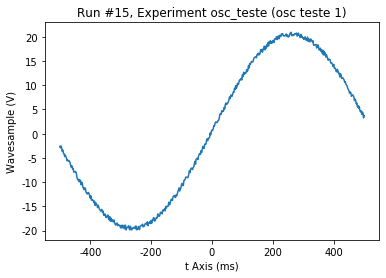

In [16]:
plot_dataset(dataset)

# Medida variando freq

In [17]:
exp = load_or_create_experiment(experiment_name='osc_teste variando freq',
                                sample_name="osc teste 1")

In [20]:
meas = Measurement(exp=exp, station=station)
meas.register_parameter(osc.ch1.wavesample)

freqs = np.linspace(1,4,10)
with meas.run() as datasaver:
    for freq in freqs:
        PSG1.freq.set(freq)
        datasaver.add_result((osc.ch1.t_axis, osc.ch1.t_axis()),
                             (osc.ch1.wavesample, osc.ch1.wavesample()))
        dataset = datasaver.dataset

Starting experimental run with id: 17. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1b616de5c88>], [None])

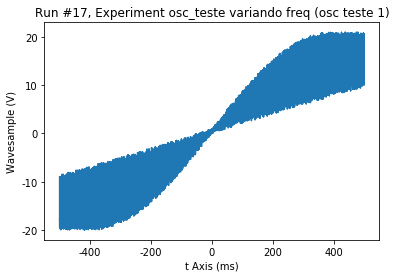

In [21]:
plot_dataset(dataset)